In [25]:
import numpy as np
import pandas as pd
import os
import copy
import xgboost
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import statsmodels.formula.api as smf
import tensorflow as tf
from scipy import stats
from scipy.stats import norm
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, confusion_matrix

os.chdir(os.getcwd())

## IMPORT DATA SET AND EXPLORATORY ANALYSIS

In [26]:
train = pd.read_csv('train_outgoing_calls.csv',header = 0)
train.drop(columns = ['w'], axis = 1, inplace = True)
test = pd.read_csv('test_outgoing_calls.csv',header = 0)

In [27]:
print(train.shape, test.shape) ## the additional variable in train is "y", our target variable

(10000, 89) (5300, 88)


In [28]:
## Change column names train data set
name_col = list(train.columns)
rename_col = [name.replace('.','_').replace(' ','_') for name in name_col]
dict_col = dict(zip(name_col,rename_col))
train.rename(columns = dict_col,inplace= True)
## Change column names test data set
name_col = list(test.columns)
rename_col = [name.replace('.','_').replace(' ','_') for name in name_col]
dict_col = dict(zip(name_col,rename_col))
test.rename(columns = dict_col,inplace= True)

In [29]:
## train test for linear regression with smf
train_smf = copy.deepcopy(train)

#### Exploring the data set
- There are no non-null cells
- Four 'object' variable: "payment", "gender", "added.service.1", "added.service.2"
- Three numerical non-ordered variable: "tariff", "area", "channel"
- 1524 customers has 0 minutes call on month 9
- Replace '.' with '_' in column names
- The target variable is skewed so it's not possible to transform with log since there are 0 so the possibility are or using log after adding a constant or use the sqrt: after trials and errors I have chosen sqrt

In [30]:
print('payment:', train.payment.unique())
print('gender:',train.gender.unique())
print('added_service_1:',train['added_service_1'].unique())
print('added_service_2:',train['added_service_2'].unique())
print('tariff:',train['tariff'].unique())
print('area:',train['area'].unique())
print('channel:',train['channel'].unique())

payment: ['post account' 'credit card' 'bank account']
gender: ['B' 'M' 'F']
added_service_1: ['N' 'Y']
added_service_2: ['N' 'Y']
tariff: [8 7 6 3 4]
area: [1 2 3 4]
channel: [5 3 9 7 8 2 6 4]


#### Setting the data set

In [31]:
## TRAIN DATA SET
dummies = pd.get_dummies(train[['payment','gender','added_service_1','added_service_2','tariff','area','channel']].astype(str), drop_first = True)
train_drop = train.drop(['payment','gender','added_service_1','added_service_2','tariff','area','channel'],axis = 1)
train = pd.concat([train_drop, dummies.astype('int')],axis = 1).rename({'payment_credit card':'payment_credit_card', 'payment_post account':'payment_post_account'},axis = 1)
## TEST DATA SET
dummies = pd.get_dummies(test[['payment','gender','added_service_1','added_service_2','tariff','area','channel']].astype(str), drop_first = True)
test_drop = test.drop(['payment','gender','added_service_1','added_service_2','tariff','area','channel'],axis = 1)
test = pd.concat([test_drop, dummies.astype('int')],axis = 1).rename({'payment_credit card':'payment_credit_card', 'payment_post account':'payment_post_account'},axis = 1)

#### Target variable analysis

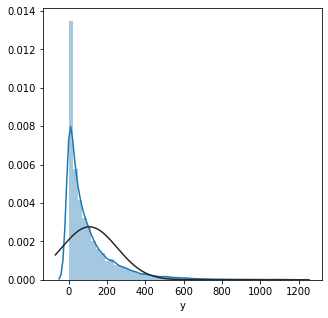

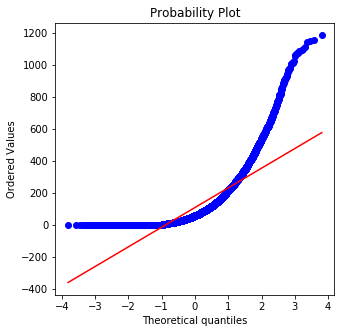

In [32]:
train.y.describe()

fig = plt.figure(figsize=(5,5))
sns.distplot(train['y'],fit=norm)
fig = plt.figure(figsize=(5,5))
res = stats.probplot(train['y'], plot=plt)

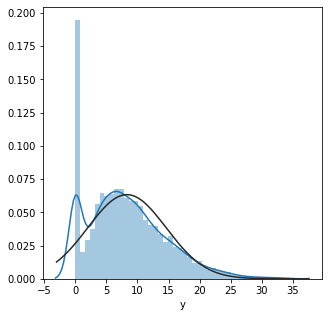

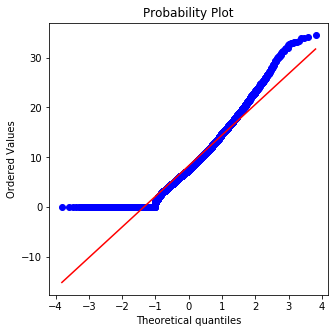

In [33]:
train['y'] = np.sqrt(train['y'])
fig = plt.figure(figsize=(5,5))
sns.distplot(train['y'],fit=norm)
fig = plt.figure(figsize=(5,5))
res = stats.probplot(train['y'], plot=plt)

Let's see later adding a constant to log

#### Correlation
Considering that we are working with time series, all the variables related to the data of the costumers on the 8 months before are higly correlated. Precisely, the most correlated variables are the out_peak_count and out_peak_duration.

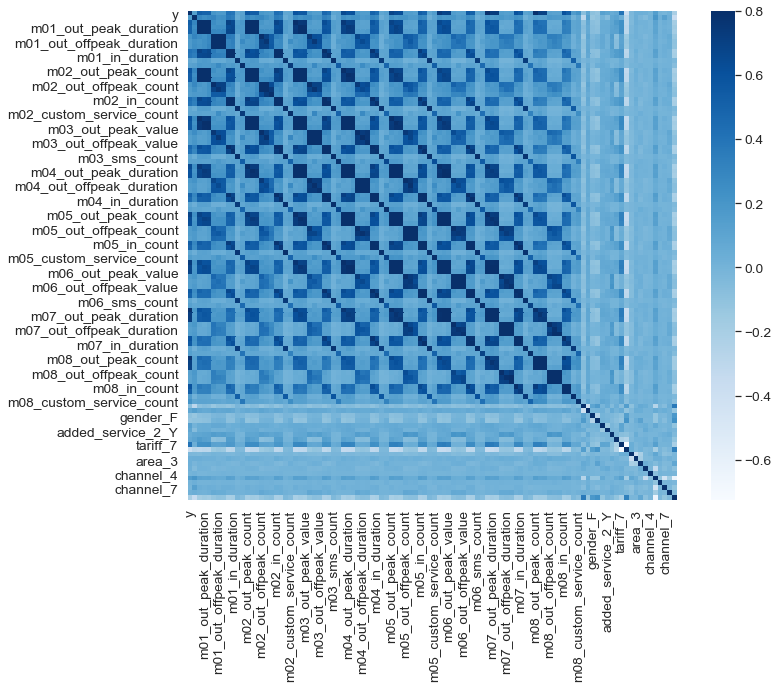

In [702]:
corrmat = train.corr()
f, ag = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax = .8, square = True, cmap = 'Blues')

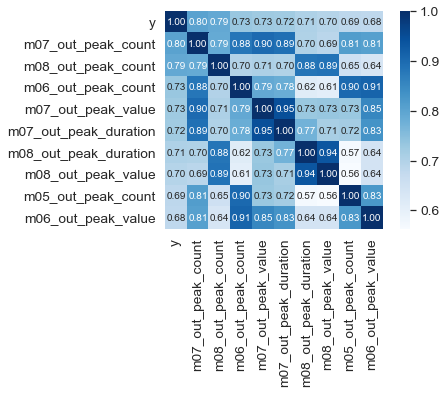

In [703]:
k = 10
cols = corrmat.nlargest(k, 'y')['y'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale = 1.25)
hm = sns.heatmap(cm, cbar = True, annot = True, square= True, fmt = '.2f', annot_kws = {'size':10}, yticklabels = cols.values, xticklabels = cols.values, cmap = 'Blues')
plt.show()

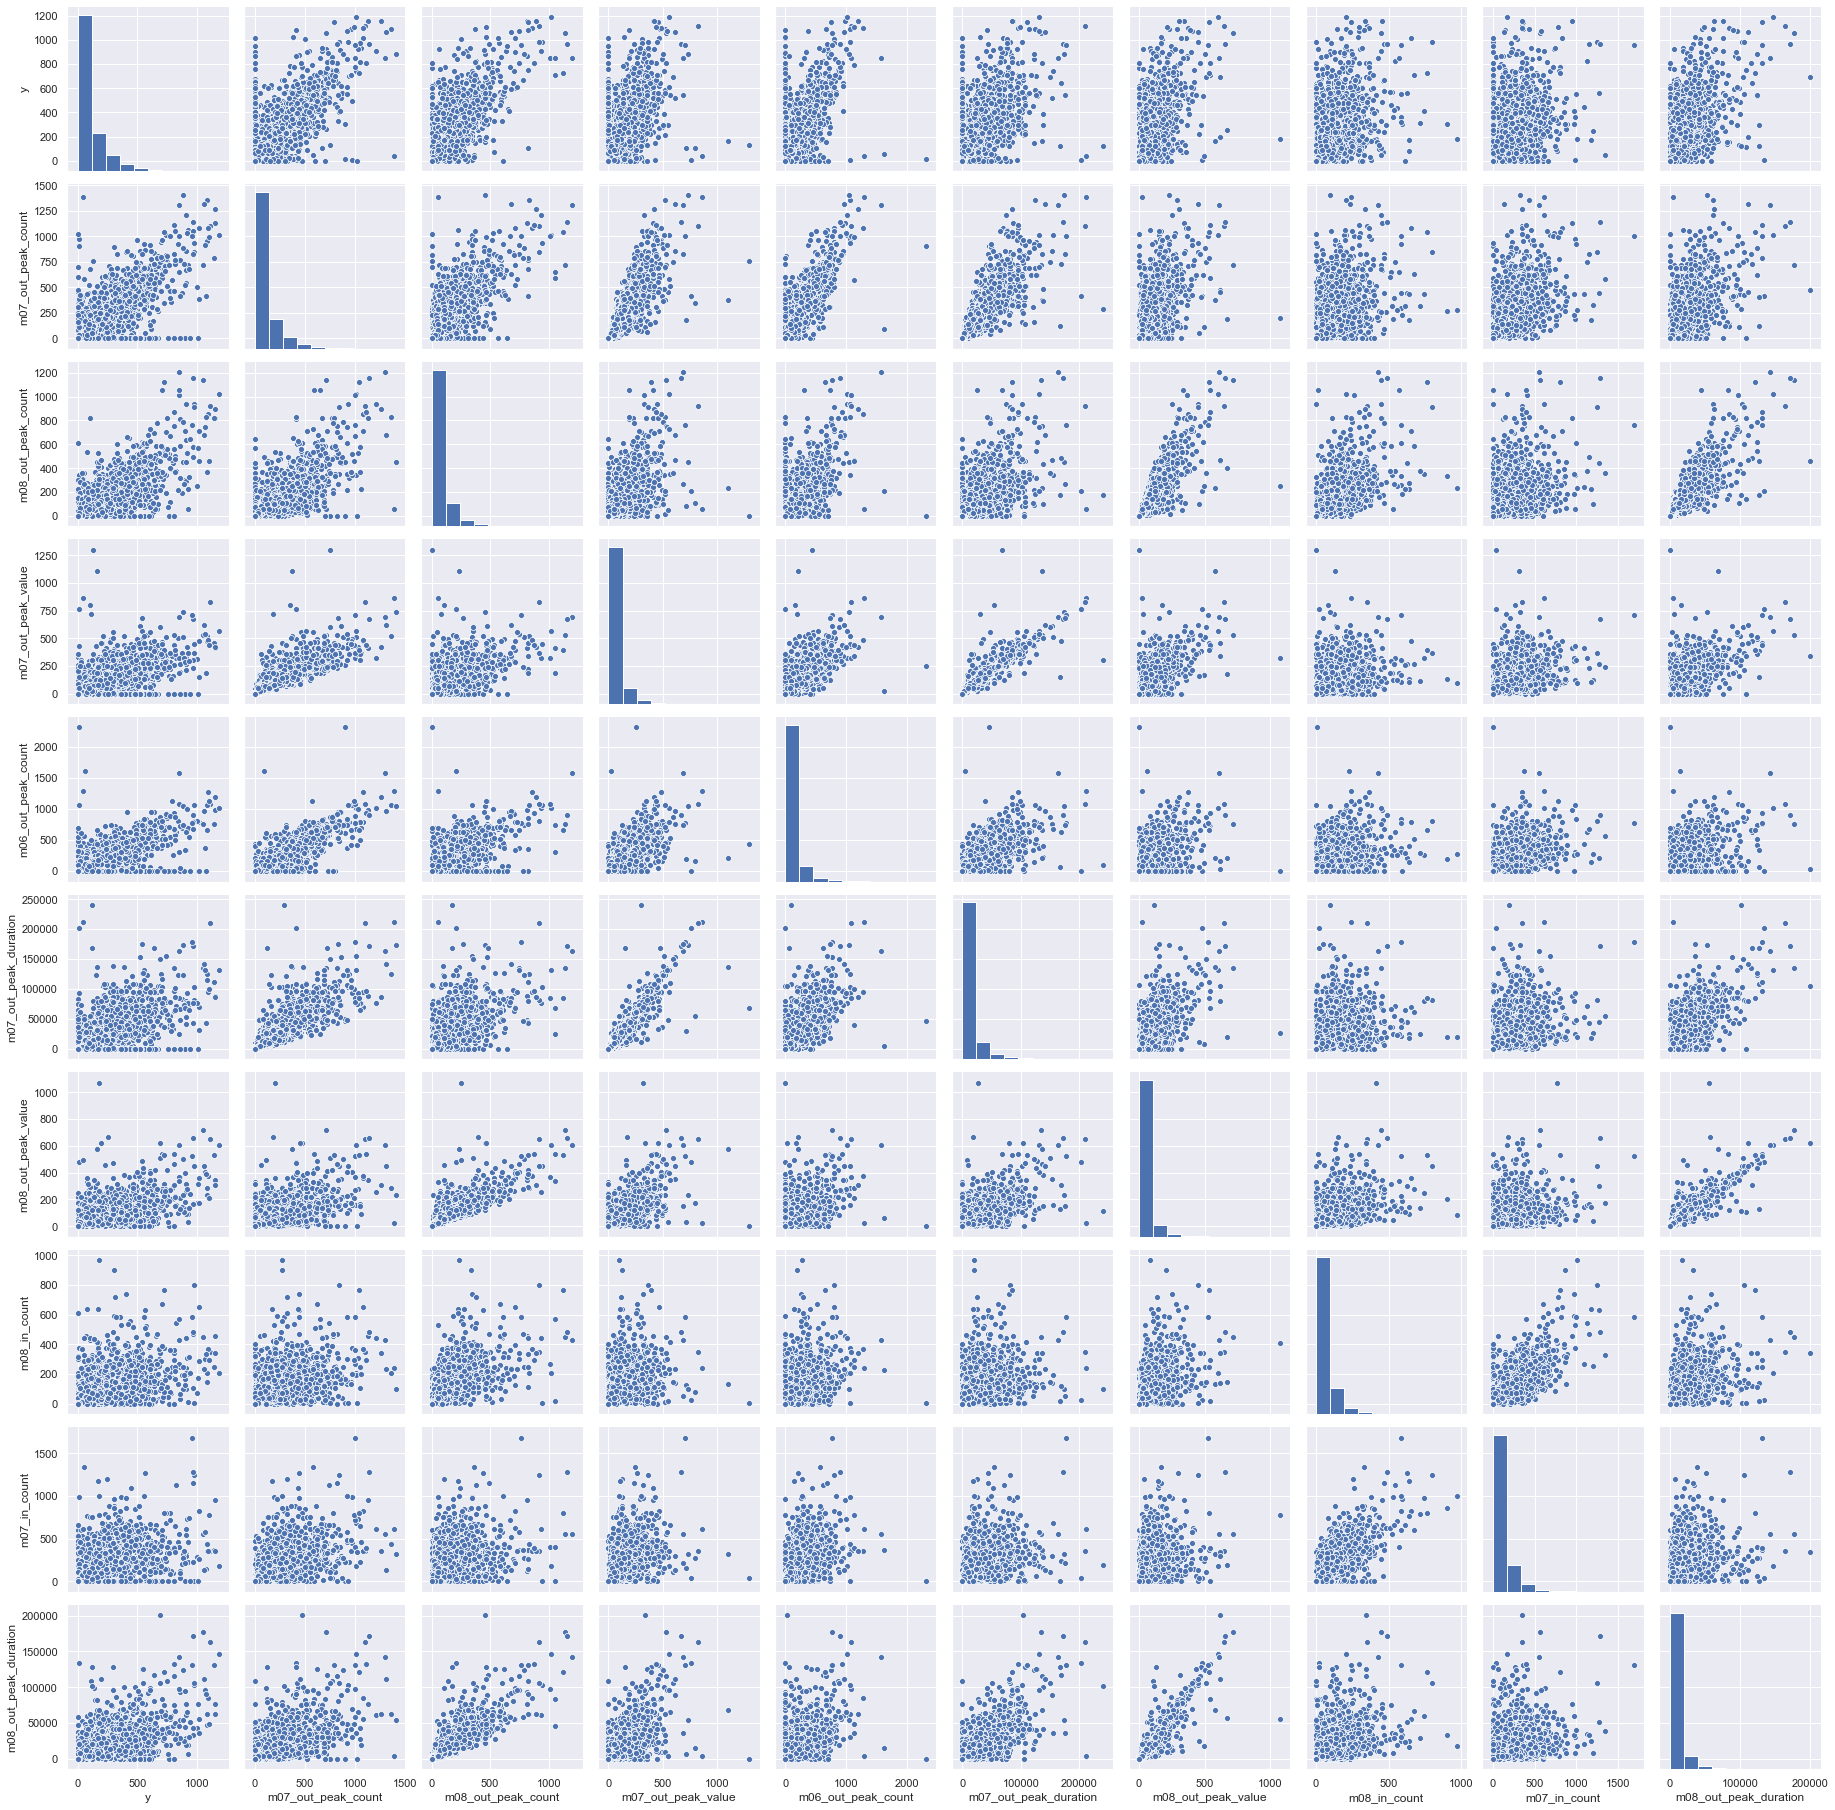

In [273]:
sns.set()
#cols = ['y', ]
sns.pairplot(train[cols], height = 2.5)
plt.show()

#### Split train in INPUT and OUTPUT

In [34]:
## Define the variable spletted between INPUT and OUTPUT
X = train.iloc[:,1:]
y = train["y"].values.reshape(-1,1)

## Linear Regression Baseline

##### Linear Regression Sklearn

In [11]:
## sklearn
lm_sk = LinearRegression()
lm_sk.fit(X,y)
lm_sk.score(X,y)

0.6726776713753778

In [12]:
## The fit is already not too bad but ADD CROSS-VALIDATION
cv_error = -cross_val_score(lm_sk, X = X, y = y, scoring = "neg_mean_absolute_error", cv = 10)

print(np.mean(cv_error))

2.7128653388213846


##### Linear Regression SMF
Change "." with "_" in columns name!!!!

In [868]:
my_regressors = "+".join(train.columns.difference(["y"]))
my_formula= "y~" + my_regressors
lm_smf = smf.ols(my_formula, data=train).fit()
print(lm_smf.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     199.6
Date:                Mon, 11 May 2020   Prob (F-statistic):               0.00
Time:                        23:25:06   Log-Likelihood:                -25809.
No. Observations:                9636   AIC:                         5.182e+04
Df Residuals:                    9537   BIC:                         5.253e+04
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

## Variable Selection

In [109]:
def getRSS(response, X, feature_list):
    my_regressors = "+".join(feature_list)
    my_formula = response + "~" + my_regressors
    model = smf.ols(my_formula, data = X).fit()
    y = X[response]
    RSS = ((model.predict() - y) ** 2).sum()
    return {'Model':model, 'RSS':RSS, 'Features':feature_list}

def bestModel(response, X, K):
    results = []
    for c in itertools.combinations(X.columns.difference([response]), K):
        results.append(getRSS(response, X, c))     
        model_all =  pd.DataFrame(results)
    
    best_model = model_all.iloc[model_all["RSS"].values.argmin()] # this could be modified to have the top several models
    return best_model

##### Forwards Stepwise Selection

In [ ]:
def forward_select(response, X, feature_list):
    remaining_predictors = [p for p in X.columns.difference([response]) if p not in feature_list]
    results = []
    for p in remaining_predictors:
        results.append(getRSS(response, X, feature_list+[p]))

    models = pd.DataFrame(results)
    best_model = models.iloc[models["RSS"].values.argmin()]
    return best_model

max_features = 11
models_forward = pd.DataFrame(columns=["RSS", "Model", "Features"])
feature_list = []
for i in range(1,len(train.columns.difference(["y"]))+1):
    models_forward.loc[i] = forward_select(response = "y", X = train, feature_list = feature_list)
    feature_list = models_forward.loc[i]["Features"]

print(models_forward.loc[max_features]["Features"])

##### Backward Stepwise Selection

In [110]:
def backward_select(response, X, feature_list):
    results = []
    for c in itertools.combinations(feature_list, len(feature_list)-1):
        results.append(getRSS(response, X, c))

    models = pd.DataFrame(results)
    best_model = models.iloc[models['RSS'].values.argmin()]
    return best_model

models_backward = pd.DataFrame(columns=["RSS", "Model", "Features"], index = range(1,len(train.columns.difference(["y"]))))
feature_list = train.columns.difference(["y"])

while(len(feature_list) > 1):
    models_backward.loc[len(feature_list)-1] = backward_select("y", train, feature_list)
    feature_list = models_backward.loc[len(feature_list)-1]["Features"]

##### Plot Forward or Stepwise Selection

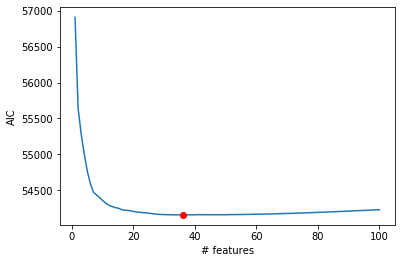

In [111]:
## AIC on FORWARD MODELS ##
aic = models_backward.apply(lambda row: row[1].aic, axis=1)
aic
## Plot AIC
plt.figure()
plt.plot(aic)
plt.plot(aic.idxmin(), aic.min(), "or") #mark the minimizer with a red point
plt.xlabel('# features')
plt.ylabel('AIC')
plt.show()

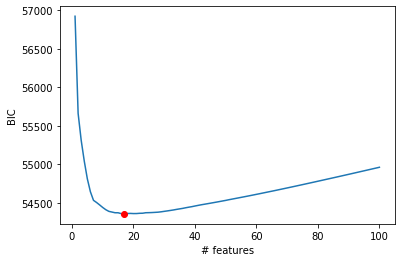

In [112]:
## BIC on FORWARD MODELS ##
bic = models_backward.apply(lambda row: row[1].bic, axis=1)
bic
## Plot BIC
plt.figure()
plt.plot(bic)
plt.plot(bic.idxmin(), bic.min(), "or") #mark the minimizer with a red point
plt.xlabel('# features')
plt.ylabel('BIC')
plt.show()

From aic the best number of parameters is 38 while from BIC it is 18.

##### Variable Selection with Cross-Validation

In [ ]:
## CROSS VALIDATION TO CHOOSE THE RIGHT NUMBER OF PARAMETER
np.random.seed(1)
train_size = np.ceil(train.shape[0]/2).astype('int32')
validation_size = 196
# create a boolean vector to specify instances to be assigned to the training set: instances in positions where 
# the vector is true are assigned to the training set. The others to the validation set
train_indices = np.zeros((train.shape[0],1),dtype=bool) 
train_indices[np.random.choice(range(0,train.shape[0]),validation_size, replace = False)] = True #set to true the positions of instances that will be assigned to the validation set

X = train.drop (['y'], axis = 1) # keep predictors and response separated
y = train.y.values.reshape(-1,1)

def getMSE_SKL_validation(y, X, feature_list, train_indices):
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_validation = X[~train_indices]
    y_validation = y[~train_indices]
    model = LinearRegression().fit(X_train[list(feature_list)],y_train)
    y_pred = model.predict(X_validation[list(feature_list)])
    MSE = mean_squared_error(y_true = y_validation, y_pred = y_pred)
    return {'Model':model, 'MSE':MSE, 'Features':feature_list}

def bestModel_SKL_validation(y, X, K, train_indices):
    results = []
    for c in itertools.combinations(X.columns, K):
        results.append(getMSE_SKL_validation(y, X, c, train_indices))     
    model_all =  pd.DataFrame(results)
    
    best_model = model_all.iloc[model_all["MSE"].values.argmin()] # this could be modified to have the top several models
    return best_model

k = 10
np.random.seed(2)
fold_assignment = np.random.choice(range(0,k+1), size = len(y), replace = True)  # Randomly assign each observations into folds
max_features = 4 # try with higher numbers
cv_errors = pd.DataFrame(columns=range(1,k+1), index=range(1,max_features + 1))

for j in range(1,k+1):
    feature_list = []
    for i in range(1,max_features+1):
        cv_errors[j][i] = bestModel_SKL_validation(y=y, X=X, K=i, train_indices=(fold_assignment!=j))["MSE"]

cv_errors_means = cv_errors.mean(axis = 1)
cv_errors_means

##### Lasso

In [979]:
names = train.iloc[:,1:].columns
scaler = StandardScaler()
scaled_df = scaler.fit_transform(train.iloc[:,1:])
X = pd.DataFrame(scaled_df, columns=names)
alphas = 10**np.linspace(6,-2,50)*0.5
alphas

lasso = Lasso(max_iter=100000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X, y)
    coefs.append(lasso.coef_)

Text(0, 0.5, 'weights')

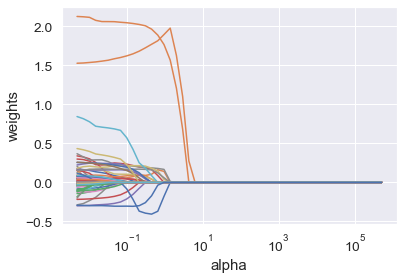

In [980]:
## Plot
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [983]:
## Choosing the best alpha
lassocv = LassoCV(alphas = None, cv = 10, max_iter= 100000)
lassocv.fit(X,y.ravel())
lasso.set_params(alpha=lassocv.alpha_)
print("Alpha=", lassocv.alpha_)
lasso.fit(X, y)
#pd.Series(lasso.coef_, index=X.columns)

Alpha= 0.018642134382410618


Lasso(alpha=0.018642134382410618, copy_X=True, fit_intercept=True,
      max_iter=100000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [984]:
## Fit with th best alpha
lasso = Lasso(max_iter=100000, alpha = lassocv.alpha_)
cv_erro_lasso = cross_val_score(lasso,X,y,cv = 10, scoring = 'neg_mean_absolute_error', n_jobs = -1)
-np.mean(cv_erro_lasso)

2.6346700347719625

##### Backward Selection Analysis

In [991]:
variable_selection_38 = ['added_service_1_Y', 'added_service_2_Y', 'age', 'area_3', 'channel_9', 'gender_F', 'gender_M', 'm01_in_count', 'm01_out_offpeak_count', 'm01_out_offpeak_value', 'm02_custom_service_count', 'm02_in_count', 'm02_out_offpeak_count', 'm02_out_peak_value', 'm03_custom_service_count', 'm03_in_duration', 'm03_out_peak_duration', 'm03_out_peak_value', 'm04_out_peak_duration', 'm04_out_peak_value', 'm05_in_count', 'm05_out_peak_count', 'm06_in_count', 'm06_out_peak_duration', 'm07_in_count', 'm07_in_duration', 'm07_out_offpeak_duration', 'm07_out_offpeak_value', 'm07_out_peak_count', 'm07_out_peak_duration', 'm08_custom_service_count', 'm08_out_offpeak_count', 'm08_out_offpeak_value', 'm08_out_peak_count', 'm08_out_peak_duration', 'payment_post_account', 'tariff_6', 'tariff_7']
check38 = train[variable_selection_38]
X_check = check38
y_check = train["y"].values.reshape(-1,1)
lm_sk = LinearRegression()
lm_sk.fit(X_check,y_check)
lm_sk.score(X_check,y_check)

0.6697608057959881

In [990]:
variable_selection_18 = ['added_service_1_Y', 'age', 'channel_9', 'gender_F', 'gender_M', 'm02_in_count', 'm02_out_peak_value', 'm04_out_peak_duration', 'm04_out_peak_value', 'm05_in_count', 'm06_out_peak_duration', 'm07_in_duration', 'm07_out_peak_count', 'm08_custom_service_count', 'm08_out_offpeak_count', 'm08_out_peak_count', 'tariff_6', 'tariff_7']
check18 = train[variable_selection_18]
X_check = check18
y_check = train["y"].values.reshape(-1,1)
lm_sk = LinearRegression()
lm_sk.fit(X_check,y_check)
lm_sk.score(X_check,y_check)

0.6677771899797695

In [989]:
variable_selection_5 = ['channel_9', 'm07_in_duration', 'm07_out_peak_count', 'm08_out_peak_count', 'tariff_7']
check5 = train[variable_selection_5]
X_check = check5
y_check = train["y"].values.reshape(-1,1)
lm_sk = LinearRegression()
lm_sk.fit(X_check,y_check)
lm_sk.score(X_check,y_check)

0.6490462270902414

In [988]:
variable_selection_3 = ['m07_out_peak_count', 'm08_out_peak_count', 'tariff_7']
check3 = train[variable_selection_3]
X_check = check3
y_check = train["y"].values.reshape(-1,1)
lm_sk = LinearRegression()
lm_sk.fit(X_check,y_check)
lm_sk.score(X_check,y_check)

0.6323597652209575

In [987]:
variable_selection_2 = ['m07_out_peak_count', 'm08_out_peak_count']
check2 = train[variable_selection_2]
X_check = check2
y_check = train["y"].values.reshape(-1,1)
lm_sk = LinearRegression()
lm_sk.fit(X_check,y_check)
lm_sk.score(X_check,y_check)

0.6199929609259016

In [986]:
variable_selection_1 = ['m08_out_peak_count']
check1 = train[variable_selection_1]
X_check = check1
y_check = train["y"].values.reshape(-1,1)
lm_sk = LinearRegression()
lm_sk.fit(X_check,y_check)
lm_sk.score(X_check,y_check)

0.540879875627932

## TREES

In [869]:
## Define the variable spletted between INPUT and OUTPUT
X = train.iloc[:,1:]
y = train["y"]

#### Decision Trees

In [250]:
## FIRST LOOK ##
regr_gini = DecisionTreeRegressor(random_state= 100)
regr_gini.fit(X, y)
-np.mean(cross_val_score(regr_gini, X = X, y = y, cv = 10, scoring = "neg_mean_absolute_error", n_jobs = 4, verbose = 1))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    3.1s finished


52.811623333333344

In [251]:
## TUNE THE PARAMETERS ##
max_depth = 10
min_samples_leaf_max = 20
max_leaf_nodes_max=20
tuned_parameters = {'max_depth': list(range(1,max_depth+1)), 'min_samples_leaf': list(range(1,min_samples_leaf_max+1)), 'max_leaf_nodes': list(range(2,max_leaf_nodes_max+1))}

clf = GridSearchCV(regr_gini, tuned_parameters, cv=3, scoring="neg_mean_absolute_error", return_train_score=True, verbose = 1, n_jobs = 4)
clf.fit(X, y)
clf.best_params_

Fitting 3 folds for each of 3800 candidates, totalling 11400 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 728 tasks      | elapsed:    9.5s
[Parallel(n_jobs=4)]: Done 1728 tasks      | elapsed:   24.4s
[Parallel(n_jobs=4)]: Done 3128 tasks      | elapsed:   50.7s
[Parallel(n_jobs=4)]: Done 4928 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 7128 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 9728 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 11400 out of 11400 | elapsed:  4.2min finished


{'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_leaf': 10}

In [252]:
## DECISION TREES WITH TUNED PARAMETERS ##
regr_gini = DecisionTreeRegressor(random_state= 100, max_depth = clf.best_params_['max_depth'], max_leaf_nodes = clf.best_params_['max_leaf_nodes'], min_samples_leaf = clf.best_params_['min_samples_leaf'])
regr_gini.fit(X, y)
-np.mean(cross_val_score(regr_gini, X = X, y = y, cv = 10, scoring = "neg_mean_absolute_error", n_jobs = 4, verbose = 1))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.4s finished


46.22532996294741

#### Bagging

In [1034]:
## FIRST LOOK ##
y = train["y"].values.ravel()
all_features = X.shape[1]
regr_bagging = RandomForestRegressor(max_features = all_features, random_state=100, n_estimators=1000, n_jobs=4)
regr_bagging.fit(X, y)
-np.mean(cross_val_score(regr_bagging, X = X, y = y, cv = 10, scoring = "neg_mean_absolute_error", n_jobs = 4, verbose = 1))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  7.6min finished


1.9603263944590588

In [1035]:
## TUNE THE PARAMETERS ##
max_depth = 20
tuned_parameters = {'max_depth': list(range(1,max_depth+1))}

clf = RandomizedSearchCV(regr_bagging, tuned_parameters, cv=10, scoring = "neg_mean_absolute_error", return_train_score=True, verbose = 1, n_jobs = 4)
clf.fit(X, y)
clf.best_params_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 19.6min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 45.7min finished


{'max_depth': 15}

In [1036]:
## BAGGING WITH TUNED PARAMETERS ##
regr_bagging = RandomForestRegressor(max_features = all_features, random_state=100, n_estimators=1000, n_jobs=4,max_depth = clf.best_params_['max_depth'])
regr_bagging.fit(X, y)
-np.mean(cross_val_score(regr_bagging, X = X, y = y, cv = 10, scoring = "neg_mean_absolute_error", n_jobs = 4, verbose = 1))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  6.1min finished


1.954905731869236

#### Random Forest

In [1037]:
## FIRST LOOK ##
regr_randomforest = RandomForestRegressor(random_state=100, n_estimators=1000, n_jobs=4)
regr_randomforest.fit(X, y)
-np.mean(cross_val_score(regr_randomforest, X = X, y = y, cv = 3, scoring = "neg_mean_absolute_error", n_jobs = 4, verbose = 1))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  1.6min finished


1.9855114996274585

In [1038]:
## TUNE THE PARAMETERS ##
max_features = 20
max_depth = 20

tuned_parameters = {'max_features': list(range(1,max_features+1)),'max_depth': list(range(1,max_depth+1))}

clf = GridSearchCV(regr_randomforest, tuned_parameters, cv=3, scoring = "neg_mean_absolute_error", return_train_score=True, verbose = 1, n_jobs = 4)
clf.fit(X, y)
clf.best_params_

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   26.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  9.2min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 25.6min
C:\Users\simon\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done 1200 out of 1200 | elapsed: 54.0min finished


{'max_depth': 20, 'max_features': 20}

In [1039]:
## RANDOM FOREST WITH TUNED PARAMETERS ##
regr_randomforest = RandomForestRegressor(max_features = clf.best_params_['max_features'], random_state=100, n_estimators=1000, n_jobs=4,max_depth = clf.best_params_['max_depth'])
regr_randomforest.fit(X, y)
-np.mean(cross_val_score(regr_randomforest, X = X, y = y, cv = 10, scoring = "neg_mean_absolute_error", n_jobs = 4, verbose = 1))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  1.7min finished


1.952730922911811

#### Boosting

In [ ]:
## FIRST LOOK ##
regr_boosting = GradientBoostingRegressor(random_state=100, n_estimators=1000)
regr_boosting.fit(X, y)
-np.mean(cross_val_score(regr_boosting, X = X, y = y, cv = 10, scoring = "neg_mean_absolute_error", n_jobs = 4, verbose = 1))

In [ ]:
## TUNE THE PARAMETERS ##
learning_rate = [0.001,0.01,0.1]
max_features = 5
max_depth = 3

tuned_parameters = {'learning_rate': learning_rate, 'max_features': list(range(1,max_depth+1)),'max_depth': list(range(1,max_depth+1))}

clf = GridSearchCV(regr_boosting, tuned_parameters, cv=3, scoring = "neg_mean_absolute_error", return_train_score=True, verbose = 2, n_jobs = 4)
clf.fit(X, y)
clf.best_params_

In [ ]:
## GRADIENT BOOSTING WITH TUNED PARAMETERS ##
regr_boosting = GradientBoostingRegressor(max_features = clf.best_params_['max_features'], random_state=100, n_estimators=1000, max_depth = clf.best_params_['max_depth'])
regr_boosting.fit(X, y)
-np.mean(cross_val_score(regr_boosting, X = X, y = y, cv = 10, scoring = "neg_mean_absolute_error", n_jobs = 4, verbose = 1))

#### XGBoost

In [1055]:
## FIRST LOOK ##
regr_xgboost = xgboost.XGBRegressor(n_estimators = 1000, n_jobs = 4)
regr_xgboost.fit(X, y)
-np.mean(cross_val_score(regr_xgboost, X = X, y = y, cv = 10, scoring = "neg_mean_absolute_error", n_jobs = 4, verbose = 1))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  3.3min finished


2.1322502576472635

In [801]:
## TUNE THE PARAMETERS ##

learning_rate = np.linspace(0,0.20,20)
max_features = 10
max_depth = 6

tuned_parameters = {'learning_rate': learning_rate, 'max_features': list(range(1,max_features+1)),'max_depth': list(range(1,max_depth+1))}

clf = GridSearchCV(regr_xgboost, tuned_parameters, cv=3, scoring = "neg_mean_absolute_error", return_train_score=True, verbose = 1, n_jobs = 4)
clf.fit(X, y)
clf.best_params_

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 27.9min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 62.1min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 114.3min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 183.5min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 266.2min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 359.7min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 472.3min
[Parallel(n_jobs=4)]: Done 3600 out of 3600 | elapsed: 535.6min finished


{'learning_rate': 0.010526315789473684, 'max_depth': 6, 'max_features': 1}

In [38]:
## BEST MODEL WITH TUNED PARAMETERS ##
regr_xgboost = xgboost.XGBRegressor(learning_rate = 0.0104, max_features = 1, random_state=100, n_estimators=1500, max_depth = 7, subsample = 0.7, colsample_bytree = 0.7, eval_metric = 'mae')
regr_xgboost.fit(X, y)
-np.mean(cross_val_score(regr_xgboost, X = X, y = y, cv = 10, scoring = "neg_mean_absolute_error", n_jobs = 4, verbose = 1))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  3.6min finished


1.9225164865017335

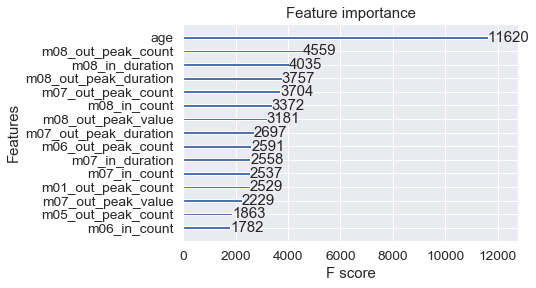

In [1040]:
xgboost.plot_importance(regr_xgboost, max_num_features = 15)

## Neural Networks

##### Split data set and standardize

In [1028]:
## SPLIT THE DATASET AND STANDARDIZE ##
train_nn, test_nn = train_test_split(train, test_size = 1000, random_state = 1)

X_train = train_nn.drop(['y'], axis=1).astype('int') # all columns contain either integer numbers or bool, and we convert everything to int
y_train = train_nn['y']
X_test = test_nn.drop(['y'], axis=1).astype('int')
y_test = test_nn['y']

scaler = StandardScaler().fit(X_train.values)

#X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
#X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

##### Model

In [ ]:
###################### DEFINE THE MODEL ####
size = 15
regularization = 0 # analog of the decay parameter in R

# define the model: 1 hidden layer with 15 nodes and one output layer with one node
reg_model = tf.keras.Sequential([
    layers.Dense(units=size, kernel_regularizer=keras.regularizers.l2(regularization), kernel_initializer='normal', activation='relu',input_shape=[X_train.shape[1]]),
    layers.Dense(1, kernel_initializer='normal')
  ])

reg_model.compile(loss='mean_absolute_error', optimizer='adam',metrics=['mean_absolute_error'])
reg_model.summary()
####################### TRAIN THE MODEL #########
nEpocs = 200
reg_model.fit(X_train,y_train, epochs=nEpocs)

####################### PREDICT #############
y_pred = reg_model.predict(X_test)
mean_absolute_error(y_test,y_pred)

In [ ]:
####################### TUNED PARAMETERS ######
np.random.seed(123)
sizeValues = range(12, 18)
regValues = np.linspace(start = 1e-3, stop = 1e-1, num = 10)

X_CV_train, X_CV_val, y_CV_train, y_CV_val = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

nEpocs = 20 # for illustration purpose we take a limited number of epocs: try with higher values
results = []
for size in sizeValues:
    for regularization in regValues:
        reg_model = tf.keras.Sequential([
            layers.Dense(units=size, kernel_regularizer=keras.regularizers.l2(regularization), kernel_initializer='normal', activation='relu',input_shape=[X_CV_train.shape[1]]),
            layers.Dense(1, kernel_initializer='normal')
              ])
        reg_model.compile(loss='mean_absolute_error', optimizer='adam',metrics=['mean_absolute_error'])
        reg_model.fit(X_CV_train,y_CV_train, epochs=nEpocs)
        y_pred = reg_model.predict(X_CV_val)
        
        results.append({'Size': size, 'Regularization': regularization, 'MSE': mean_absolute_error(y_pred,y_CV_val)})

CV_MSE_table =  pd.DataFrame(results)
CV_MSE_table

In [ ]:
######################### FIT WITH BEST PARAMETERS ####
best_model_index = CV_MSE_table['MSE'].idxmin()
bestSize = CV_MSE_table['Size'][best_model_index]
bestReg = CV_MSE_table['Regularization'][best_model_index]

nEpocs = 300
reg_model = tf.keras.Sequential([
    layers.Dense(units=bestSize, kernel_regularizer=keras.regularizers.l2(bestReg), kernel_initializer='normal', activation='relu',input_shape=[X_train.shape[1]]),
    layers.Dense(1, kernel_initializer='normal')
  ])
reg_model.compile(loss='mean_absolute_error', optimizer='adam',metrics=['mean_absolute_error'])
reg_model.fit(X_train,y_train, epochs=nEpocs)

In [1033]:
########################## PREDICT WITH BEST PARAMETERS #####
y_pred = reg_model.predict(X_test)
mean_absolute_error(y_test,y_pred)

2.22301945402128

## Stacking

In [457]:
train_nn, test_nn = train_test_split(train, test_size = 1000, random_state = 1)

X_train = train_nn.drop(['y'], axis=1).astype('int').reset_index(drop = True) # all columns contain either integer numbers or bool, and we convert everything to int
y_train = train_nn['y'].reset_index(drop = True)
X_test = test_nn.drop(['y'], axis=1).astype('int').reset_index(drop = True)
y_test = test_nn['y'].reset_index(drop = True)

In [458]:
F_X = np.zeros((X_train.shape[0],2))

In [459]:
regr_bagging = RandomForestRegressor(max_features = all_features, random_state=100, n_estimators=1000, n_jobs=4,max_depth = 13)
regr_bagging.fit(X, y.ravel())
regr_xgboost = xgboost.XGBRegressor(learning_rate = 0.010526315789473684,max_features = 1, random_state=100, n_estimators=1000, max_depth = 8)
regr_xgboost.fit(X, y.ravel())
for i in range(X_train.shape[0]):
    #regr_bagging.fit(X_train.drop(i),y_train.drop(i))
    #regr_xgboost.fit(X_train.drop(i),y_train.drop(i))
    
    F_X[i,0] = regr_bagging.predict(X_train.iloc[[i,]])
    F_X[i,1] = regr_xgboost.predict(X_train.iloc[[i,]])
    #print(i)
F_X

array([[ 63.86563981,  47.43394852],
       [394.94048139, 387.3659668 ],
       [ 69.0297835 ,  34.34183884],
       ...,
       [  8.58913232,   5.45709181],
       [  3.01395694,   8.88399601],
       [ 86.4653407 ,  84.91281891]])

In [460]:
w = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(F_X),F_X)),np.transpose(F_X)),y_train)

In [470]:
regr_bagging.fit(X_train,y_train)
regr_xgboost.fit(X_train,y_train)

y1_pred = regr_bagging.predict(X_test)
y2_pred = regr_xgboost.predict(X_test)

In [471]:
y_stack_pred = w[0]*y1_pred+ w[1]*y2_pred

In [472]:
[mean_absolute_error(y_test, y1_pred), mean_absolute_error(y_test,y2_pred), mean_absolute_error(y_test,y_stack_pred)]

[38.308049775153194, 37.10909628897905, 37.249121823041484]

## BEST MODEL PREDICTION TO UPLOAD

In [1207]:
y_pred = regr_xgboost.predict(test)
y_pred = (y_pred)**2

In [1208]:
np.savetxt('outgoing_calls_prediction.txt',y_pred)